## Summary
MLEnd dataset is a dataset of spoken numerals collected in 2021. It consists of 20,000 audio files. 4 different intonations have been used (neutral, bored, excited and question), each one is evenly represented within the dataset. This solution is attemmpting to use a machine learning algorithm in order to predict what intonation the numeral is spoken in based on features extracted from the audio file.

In [1]:
#library import
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from random import randrange

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset preparation

Check that the dataset has been donwloaded and is available for use - there should be 20,000 files.

In [3]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

Check the dataset information from the 'trainingMLEnd.csv' file and save them to a variable.

In [4]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels.head()

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited


Let's explore how many files per intonation there are

In [5]:
intonation_count = labels.groupby(['intonation']).count()
intonation_count

,File ID,digit_label,participant
intonation,,,
bored,5000,5000,5000
excited,5000,5000,5000
neutral,5000,5000,5000
question,5000,5000,5000


This shows that files are evenly split between intonations, we have 5000 samples of each type of intonation.

## Feature extraction
In order to predict the intonation of the speaker from the audio files, features contained in the audio files can be used.

The code below picks a random integer from 0 to 19999 and then plots the corresponding audio file as a time series.

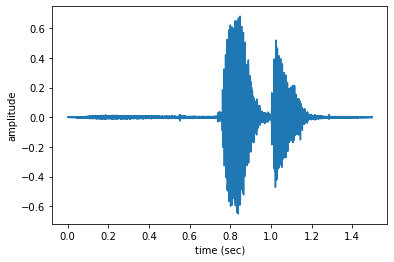

In [6]:
n = (randrange(20000))
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

The helper function below will be later used to extract some of the features of an audio file.

In [7]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

I will extract 10 different features from each audio file. I will then check which ones are useful in predicting the intonation. The feautres I will look at are:<br>
- power
- pitch mean
- pitch standard deviation
- fraction of voiced region
- zero crossing rate
- spectral centroid
- spectral rolloff
- spectral bandwidth
- chroma stft
- rmse

References:<br>
https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d<br>
https://medium.com/@alexandro.ramr777/audio-files-to-dataset-by-feature-extraction-with-librosa-d87adafe5b64<br>


The following function takes a number of files and creates a NumPy array containing the specified audio features used as predictors (`X`) and their labels (`y`).

In [8]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y,z =[],[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    # yi is our label - in this case intonation
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    zi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
        
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    crossing_rate = np.sum(librosa.feature.zero_crossing_rate(x))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(x, fs))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(x, fs))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(x, fs))
    chroma_stft = np.mean(librosa.feature.chroma_stft(x, fs))
    rmse = np.mean(librosa.feature.rms(x))
    

    xi = [power,pitch_mean,pitch_std,voiced_fr, crossing_rate, spectral_centroid, 
          spectral_rolloff, spectral_bandwidth, chroma_stft,rmse]
    X.append(xi)
    y.append(yi)
    z.append(zi)
  return np.array(X),np.array(y), np.array(z)

## Preprocessing
In this section, I will use the above function to extract the features from a proportion of audio files to aid selecting the features most useful in predicting the intonation.

Apply the getXy function to 5000 files. I am only using a small number of files here, because extracting 10 features from all files would take a long time. Once I select which features are most useful, I will use all audio files for training the model.

In [9]:
X,y,z = getXy(files[:5000],labels_file=labels,scale_audio=True, onlySingleDigit=False)

 10%|▉         | 480/5000 [04:19<43:43,  1.72it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████| 5000/5000 [43:55<00:00,  1.90it/s]


Check the shape of `X` (features) and `y` (intonations):

In [10]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (5000, 10)
The shape of y is (5000,)


### Feature selection


For slecting which features are most useful, I will use logistic regression as a model. Once I select the features, I will try out different models.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [12]:
from google.colab import widgets
import operator
import itertools

# set up a dataframe for storing results
columns = ['Features', 'No of features', 'Testing', 'Validation']
features_results = pd.DataFrame(columns=columns)
data = []

# I want to check the combination of any of the features, from using each
# individual feature, to using all 10 at the same time.
no_features = range(1,11)
tb = widgets.TabBar([str(number) for number in no_features])

for number in no_features:
    with tb.output_to(str(number), select= (number < 2)):

      # set up combinations
      for n in (itertools.combinations(range(10), number)):
        # need them displayed as a list
        tmp = []
        [tmp.append(i) for i in n]
        # only select the features from current combination  
        XX = X[:,tmp]
        X_train, X_val, y_train, y_val = train_test_split(XX,y,test_size=0.4)
        # normalise the predictors
        X_train = (X_train-X_train.mean(0))/X_train.std(0)
        X_val = (X_val-X_val.mean(0))/X_val.std(0)
        model = LogisticRegression()
        model.fit(X_train,y_train)
          

        yt_p = model.predict(X_train)
        yv_p = model.predict(X_val)
        # set up variables for appending to a data frame
        values = [n,number,np.mean(yt_p==y_train),np.mean(yv_p==y_val)]
        zipped = zip(columns, values)
        a_dictionary = dict(zipped)
        data.append(a_dictionary) 

      # append results to a data frame
      features_results = features_results.append(data, True)

      # select the part of the dataframe containing current no of features only
      result = features_results.loc[features_results['No of features'] == number]
      # sort them by testing metric
      result = result.sort_values(by=['Validation'], ascending=False)
      print(result.head().to_string())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Features No of features   Testing  Validation
2     (2,)              1  0.462333      0.4565
1     (1,)              1  0.367333      0.3590
9     (9,)              1  0.301667      0.3065
3     (3,)              1  0.296333      0.3020
0     (0,)              1  0.287667      0.2985


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Features No of features   Testing  Validation
43   (2, 9)              2  0.500333      0.5020
21   (0, 2)              2  0.489667      0.4930
37   (2, 3)              2  0.504667      0.4855
39   (2, 5)              2  0.468667      0.4750
42   (2, 8)              2  0.481333      0.4740


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

      Features No of features   Testing  Validation
184  (2, 3, 4)              3  0.505333      0.5210
128  (0, 2, 3)              3  0.508000      0.5195
194  (2, 4, 9)              3  0.509667      0.5175
201  (2, 6, 9)              3  0.492667      0.5125
189  (2, 3, 9)              3  0.522333      0.5100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         Features No of features   Testing  Validation
578  (2, 4, 7, 9)              4  0.505667      0.5320
573  (2, 4, 5, 9)              4  0.508667      0.5280
579  (2, 4, 8, 9)              4  0.505667      0.5235
566  (2, 3, 6, 9)              4  0.512000      0.5200
449  (0, 2, 4, 5)              4  0.507333      0.5200


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

             Features No of features   Testing  Validation
1209  (2, 3, 4, 5, 9)              5  0.538000      0.5450
1234  (2, 4, 6, 8, 9)              5  0.512333      0.5365
1067  (0, 2, 3, 4, 6)              5  0.531000      0.5335
1013  (0, 1, 2, 3, 7)              5  0.509667      0.5315
1066  (0, 2, 3, 4, 5)              5  0.533667      0.5285


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                Features No of features   Testing  Validation
2082  (2, 3, 4, 5, 6, 8)              6  0.529667      0.5495
2081  (2, 3, 4, 5, 6, 7)              6  0.504000      0.5490
2086  (2, 3, 4, 5, 8, 9)              6  0.533333      0.5470
1970  (0, 2, 3, 4, 5, 7)              6  0.526333      0.5410
1900  (0, 1, 2, 3, 4, 6)              6  0.529667      0.5400


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                   Features No of features   Testing  Validation
2984  (0, 1, 2, 4, 6, 8, 9)              7  0.513667      0.5490
3069  (2, 3, 4, 5, 6, 7, 9)              7  0.536667      0.5455
3013  (0, 2, 3, 4, 5, 6, 8)              7  0.528333      0.5435
3047  (1, 2, 3, 4, 6, 7, 9)              7  0.529667      0.5420
2982  (0, 1, 2, 4, 6, 7, 8)              7  0.514333      0.5415


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                      Features No of features   Testing  Validation
4046  (0, 1, 2, 3, 4, 5, 7, 8)              8  0.525667      0.5485
4081  (1, 2, 3, 4, 5, 6, 8, 9)              8  0.530000      0.5375
4073  (0, 2, 3, 4, 5, 6, 8, 9)              8  0.534667      0.5355
4043  (0, 1, 2, 3, 4, 5, 6, 7)              8  0.534000      0.5345
4079  (1, 2, 3, 4, 5, 6, 7, 8)              8  0.537333      0.5320


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                         Features No of features   Testing  Validation
5109  (1, 2, 3, 4, 5, 6, 7, 8, 9)              9  0.552667      0.5385
5103  (0, 1, 2, 3, 4, 5, 7, 8, 9)              9  0.538333      0.5375
5102  (0, 1, 2, 3, 4, 5, 6, 8, 9)              9  0.523000      0.5335
5106  (0, 1, 2, 4, 5, 6, 7, 8, 9)              9  0.528333      0.5335
5108  (0, 2, 3, 4, 5, 6, 7, 8, 9)              9  0.530667      0.5305


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                            Features No of features   Testing  Validation
6132  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)             10  0.536667      0.5375


<IPython.core.display.Javascript object>

From looking at single feature, feature with index 2 (pitch standard deviation) is the best at predicting the intonation. Generally, increasing the number of features improves the quality of prediction - however this plateaus at 6 features. When using a large number of features, the results remain more or less the same, no specific set of features seem to perform much better than others. I also tested this on different subsets of data and there was no specific 'winning' combination of features.<br><br> Next, I will to look at top validation results in order to make my feature selection.

In [13]:
# remove duplicated entries from my data frame
features_results = features_results.drop_duplicates()
# sort by validation
features_results = features_results.sort_values(by=['Validation'], ascending=False)
# only display the top result
features_results.head(10)

,Features,No of features,Testing,Validation
2082,"(2, 3, 4, 5, 6, 8)",6,0.529667,0.5495
2984,"(0, 1, 2, 4, 6, 8, 9)",7,0.513667,0.5490
2081,"(2, 3, 4, 5, 6, 7)",6,0.504000,0.5490
4046,"(0, 1, 2, 3, 4, 5, 7, 8)",8,0.525667,0.5485
2086,"(2, 3, 4, 5, 8, 9)",6,0.533333,0.5470
3069,"(2, 3, 4, 5, 6, 7, 9)",7,0.536667,0.5455
1209,"(2, 3, 4, 5, 9)",5,0.538000,0.5450
3013,"(0, 2, 3, 4, 5, 6, 8)",7,0.528333,0.5435
3047,"(1, 2, 3, 4, 6, 7, 9)",7,0.529667,0.5420
3072,"(2, 3, 4, 6, 7, 8, 9)",7,0.535333,0.5415


I want to use as few features as possible, as using too many features could lead to overfitting. It would also take longer to train the model. Features with index 2, 3, 4, 5, 6 and 8 show the best validation performance. There are a few other subsets with very similar performance, however the fewer features I use the better. Hence I will select these for my model.


### Choosing a model
Now that I have selected the features to use, I will evaluate a few different models in order to pick the one that performs best at predicting the intonation of an audio file.

In [14]:
# import some widely used prediction models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
# decision tree classifier
from sklearn import tree

In [15]:
# set up a dataframe for storing results
columns = ['Model', 'Testing', 'Validation']
models_results = pd.DataFrame(columns=columns)

# helper function that runs each model
def runModel(model_name):
  model.fit(X_train,y_train)
  yt_p = model.predict(X_train)
  yv_p = model.predict(X_val)

  data = {'Model': model_name, 'Testing': np.mean(yt_p==y_train), 
        'Validation':np.mean(yv_p==y_val)}
  return data
  

# select the feautures extracted
XX = X[:,[2, 3, 4, 5, 6, 8]]
X_train, X_val, y_train, y_val = train_test_split(XX,y,test_size=0.4)
# normalise the predictors
X_train = (X_train-X_train.mean(0))/X_train.std(0)
X_val = (X_val-X_val.mean(0))/X_val.std(0)

## run a number of models
# Logistic Regression
model = LogisticRegression()
data = runModel('Logistic Regression')
models_results = models_results.append(data, ignore_index=True)

# Support Vector Machine
model  = svm.SVC(C=1)
data = runModel('SVM_c1')
models_results = models_results.append(data, ignore_index=True)

model  = svm.SVC(C=2)
data = runModel('SVM_c2')
models_results = models_results.append(data, ignore_index=True)

model  = svm.SVC(C=3)
data = runModel('SVM_c3')
models_results = models_results.append(data, ignore_index=True)

# Support Vector Machine with c and gamma
model  = svm.SVC(C=1,gamma=2)
data = runModel('SVM_g2')
models_results = models_results.append(data, ignore_index=True)

model  = svm.SVC(C=2,gamma=2)
data = runModel('SVM_g2')
models_results = models_results.append(data, ignore_index=True)

model  = svm.SVC(C=2,gamma=3)
data = runModel('SVM_g2')
models_results = models_results.append(data, ignore_index=True)

# Normal Decision Tree
model = tree.DecisionTreeClassifier()
data = runModel('Decision Tree')
models_results = models_results.append(data, ignore_index=True)

# Decision Tree depth 4
model = tree.DecisionTreeClassifier(max_depth=4)
data = runModel('Decision Tree depth=4')
models_results = models_results.append(data, ignore_index=True)

# Decision Tree depth 5
model = tree.DecisionTreeClassifier(max_depth=5)
data = runModel('Decision Tree depth=5')
models_results = models_results.append(data, ignore_index=True)

# Decision Tree depth 6
model = tree.DecisionTreeClassifier(max_depth=6)
data = runModel('Decision Tree depth=6')
models_results = models_results.append(data, ignore_index=True)

models_results

,Model,Testing,Validation
0,Logistic Regression,0.536000,0.5170
1,SVM_c1,0.589000,0.5345
2,SVM_c2,0.597333,0.5390
3,SVM_c3,0.602333,0.5340
4,SVM_g2,0.763667,0.5315
5,SVM_g2,0.839667,0.5215
6,SVM_g2,0.903000,0.4910
7,Decision Tree,1.000000,0.4025
8,Decision Tree depth=4,0.534667,0.4775
9,Decision Tree depth=5,0.564000,0.4855


I have re run the above code a few times and changed some of the parameters, I only included the best results here.<br>
**Notes**
- Logistic Regression produced validation of 0.5-0.55
- Support Vector Machines generally achieve similar performance, with better testing and slightly better validation, hence these are worth exploring further
- Support Vector Machine with different `c` and `gamma` values are overfitting, however, they do show some promise and are worth exploring further
- standard Decistion Tree ovefits entirely, however, limiting the depth of the tree achieves better results

Out of the above, linear Support Vector Machines seem to be showing best result. I want to explore them further - both just with adjusting the `c` parameter and adjusing both `c` and `gamma` parameters. Below, I am going to explore Support Vector Machines further, first with both `c` and `gamma`, then only with `c` hyperparameters.

#### Support Vector Machines with different `c` and `gamma`
I am going to look at paremter `c` between 0.1 and 100 and `gamma` between 0.0001 and 10.<br>
Reference:<br>
https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167

As looking at many values in those two ranges would take significant time and resources, I first looked at 100 values of `c` and 100 values of `gamma`. This indicated that `gamma` values close to 0.1 produce the best result together with `c` values of 6 or 7. I then rerun the test with 2 values of `c` (6 and 7) and 98 values of `gamma` (0.01 to 1).

In [17]:
# set up a dataframe for storing results
svm_columns = ['C', 'G', 'Testing', 'Validation']
SVM_results = pd.DataFrame(columns=svm_columns)

# helper function that runs each model
def runModel(c, gamma):
  model.fit(X_train,y_train)
  yt_p = model.predict(X_train)
  yv_p = model.predict(X_val)

  data = {'C': str(c), 'G': str(gamma), 'Testing': np.mean(yt_p==y_train), 
        'Validation':np.mean(yv_p==y_val)}
  return data
  

# select the feautures extracted
XX = X[:,[2, 3, 4, 5, 6, 8]]
X_train, X_val, y_train, y_val = train_test_split(XX,y,test_size=0.4)
# normalise the predictors
X_train = (X_train-X_train.mean(0))/X_train.std(0)
X_val = (X_val-X_val.mean(0))/X_val.std(0)

c_parameter = np.arange(6, 7, 1).tolist()
gamma_parameter = np.arange(0.01, 0.99, 0.01).tolist()

for c in c_parameter:
  for gamma in gamma_parameter:
    model  = svm.SVC(C=c,gamma=gamma)
    data = runModel(c, gamma)
    SVM_results = SVM_results.append(data, ignore_index=True)

# sort the results by validation
SVM_results = SVM_results.sort_values(by=['Validation'], ascending=False)
# only display the top result
SVM_results.head(10)

,C,G,Testing,Validation
27,6,0.28,0.648000,0.5760
28,6,0.29000000000000004,0.649667,0.5750
21,6,0.22,0.630667,0.5740
29,6,0.3,0.655667,0.5740
25,6,0.26,0.641000,0.5740
22,6,0.23,0.631667,0.5740
26,6,0.27,0.644333,0.5735
14,6,0.15000000000000002,0.604333,0.5735
12,6,0.13,0.597000,0.5730
23,6,0.24000000000000002,0.635333,0.5730


Using different `c` and `gamma` parameters improved the validation performance slightly. The best validation I achieved was 0.57. However, the testing score was much higher - 0.65, which might suggest that the model is overfitting. In the end it is the validation I am more interested in though.

#### Support Vector Machine C parameter exploration
Below I will explore running Support Vector Machine model with different values of `c` parameter. I will look at values of `c` between 0.1 and 100

In [19]:
# set up a dataframe for storing results
svm_c_columns = ['C', 'Testing', 'Validation']
SVM_c_results = pd.DataFrame(columns=svm_c_columns)

# helper function that runs each model
def runModel(c):
  model.fit(X_train,y_train)
  yt_p = model.predict(X_train)
  yv_p = model.predict(X_val)

  data = {'C': str(c), 'Testing': np.mean(yt_p==y_train), 
        'Validation':np.mean(yv_p==y_val)}
  return data
  

# select the feautures extracted
XX = X[:,[2, 3, 4, 5, 6, 8]]
X_train, X_val, y_train, y_val = train_test_split(XX,y,test_size=0.4)
# normalise the predictors
X_train = (X_train-X_train.mean(0))/X_train.std(0)
X_val = (X_val-X_val.mean(0))/X_val.std(0)

c_parameter = np.arange(0.5, 100, 0.5).tolist()

for c in c_parameter:
  model  = svm.SVC(C=c)
  data = runModel(c)
  SVM_c_results = SVM_c_results.append(data, ignore_index=True)

# sort the results by validation
SVM_c_results = SVM_c_results.sort_values(by=['Validation'], ascending=False)
# only display the top result
SVM_c_results.head(10)

,C,Testing,Validation
0,0.5,0.560667,0.5625
1,1.0,0.574000,0.5625
2,1.5,0.579333,0.5580
3,2.0,0.580000,0.5555
4,2.5,0.584333,0.5500
5,3.0,0.587333,0.5455
6,3.5,0.594333,0.5440
7,4.0,0.595333,0.5430
8,4.5,0.597000,0.5395
9,5.0,0.599000,0.5375


The result indicate that `c` value of 0.5 produces the best results, achieving validation of around 0.56, as this is lower than the result for vector machine using both `c` and `gamma`, I am going to use the previous specification in my final model.

### The model
My final model will use the following features extracted from the audio files (index, name):
- 2, pitch standard deviation
- 3, fraction of voiced region
- 4, zero crossing rate
- 5, spectral centroid
- 6, spectral rolloff
- 8, chroma stft<br><br>

The model used will be a **Support Vector Machine** with hyperparamter `c` set to 6 and `gamma` parameter set to 0.28.<br><br>
Using this model on a subset of the whole dataset produced correct training prediction 65% of the time and validation prediction 57% of the time. In the next section, I will run this model on the whole dataset available.

## Training and validation
For training of the model I will use all 20,000 sound files. I am going to create a dataset of all files with all ten features and save it as csv for future use. This task will take a long time and therefore I only want to do it once. One audio file was causing errors, therefore I will end up with 3 csv files of length 19999 each:
- `feeatures.csv` - all 10 features I identified earlier - I extracted all 10 in case they could be useful for any further exploration
- `intonations.csv` - corresponding intonations
- `numerals.csv` - corresponding numerals - while I am not using them in this model, I kept them as they might prove useful elsewhere<br><br>

These files can also be downloaded from my GitHub:<br>
https://github.com/maciejtarsa/MLEnd-Spoken-Numerals

In [20]:
# the next line is commented out because I only needed to run it once
#X,y,z = getXy(files[:],labels_file=labels,scale_audio=True, onlySingleDigit=False)

Instead of the above line, I will import the csv files I have created. I will import the features into a vector `X` and the intonations into a vector `y`.

In [21]:
import csv
# import the features from a csv file into an array
data_x = []
with open('/content/drive/MyDrive/Data/MLEnd/features.csv', 'r') as rf:
    reader = csv.reader(rf, delimiter=',')
    for row in reader:
      data_x.append(row[1:11])

# set it as an array
X = np.array(data_x).astype(np.float)
# remove the 'header'
X = np.delete(X, 0, axis=0)

# import the intonations from a csv file into an array
data_y=[]
with open('/content/drive/MyDrive/Data/MLEnd/intonations.csv', 'r') as rf:
    reader = csv.reader(rf, delimiter=',')
    for row in reader:
      data_y.append(row[1])

# set it as an array
y = np.array(data_y)
# remove the 'header'
y = np.delete(y, [0])

### Run the model
In this section, I will run the model on the full dataset

In [24]:
# select the feautures extracted
XX = X[:,[2, 3, 4, 5, 6, 8]]
X_train, X_val, y_train, y_val = train_test_split(XX,y,test_size=0.4)
# normalise the predictors
X_train = (X_train-X_train.mean(0))/X_train.std(0)
X_val = (X_val-X_val.mean(0))/X_val.std(0)

# run the model
model  = svm.SVC(C=6, gamma=0.28)
model.fit(X_train,y_train)
yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print("The final model produced the following testing and validation values:")
print(f"Testing: {np.mean(yt_p==y_train)}")
print(f"Validation: {np.mean(yv_p==y_val)}")

The final model produced the following testing and validation values:
Testing: 0.6219684973747812
Validation: 0.58375


My final model achieved the testing accuracy of 62% and validation accuracy of 58% using a dataset of 19999 audio files.

Having listened to some of the audio files, I personally found it really hard to tell what intonation the speaker was trying to express. It would be interesting to see the confusion matrix for different intonations and calculate their sensitivities and specificities. I will use the validation subset for this task.

### Confusion matrix

Set up a data frame for storing results for each intonation.

In [25]:
# set up a dataframe for storing results
intonations_columns = ['Intonation', 'Sensitivity', 'Specificity']
intonations_results = pd.DataFrame(columns=intonations_columns)

In [26]:
# generate the confusion matrix
confusion_matrix = pd.crosstab(yv_p, y_val, rownames=['Actual'], colnames=['Predicted'], margins=True)
# and print it
print('Confusion Matrix for neutral : \n\n', confusion_matrix)

# create a simple matrix to use for calculations
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(yv_p, y_val)

# calculate sensitivities
sensitivity_bored = con_matrix[0,0]/sum(con_matrix[0,0:4])
sensitivity_excited = con_matrix[1,1]/sum(con_matrix[1,0:4])
sensitivity_neutral = con_matrix[2,2]/sum(con_matrix[2,0:4])
sensitivity_question = con_matrix[3,3]/sum(con_matrix[3,0:4])

# calculate specificities
specificity_bored = sum(sum(con_matrix[1:4,1:4]))/(con_matrix[1,1]+
                     con_matrix[1,2]+con_matrix[1,3]+
                     con_matrix[2,1]+con_matrix[2,2]+con_matrix[2,3]+
                     con_matrix[3,1]+con_matrix[3,2]+con_matrix[3,3]+
                     con_matrix[0,1]+con_matrix[0,2]+con_matrix[0,3])
specificity_excited = (con_matrix[0,0]+con_matrix[0,2]+con_matrix[0,3]+
                     con_matrix[2,0]+con_matrix[2,2]+con_matrix[2,3]+
                     con_matrix[3,0]+con_matrix[3,2]+con_matrix[3,3])/(con_matrix[0,0]+
                     con_matrix[0,2]+con_matrix[0,3]+
                     con_matrix[2,0]+con_matrix[2,2]+con_matrix[2,3]+
                     con_matrix[3,0]+con_matrix[3,2]+con_matrix[3,3]+
                     con_matrix[1,0]+con_matrix[1,2]+con_matrix[1,3])
specificity_neutral = (con_matrix[0,0]+con_matrix[0,1]+con_matrix[0,3]+
                     con_matrix[1,0]+con_matrix[1,1]+con_matrix[1,3]+
                     con_matrix[3,0]+con_matrix[3,1]+con_matrix[3,3])/(con_matrix[0,0]+
                     con_matrix[0,1]+con_matrix[0,3]+
                     con_matrix[1,0]+con_matrix[1,1]+con_matrix[1,3]+
                     con_matrix[3,0]+con_matrix[3,1]+con_matrix[3,3]+
                     con_matrix[2,0]+con_matrix[2,1]+con_matrix[2,3])
specificity_question = (con_matrix[0,0]+con_matrix[0,1]+con_matrix[0,2]+
                     con_matrix[1,0]+con_matrix[1,1]+con_matrix[1,2]+
                     con_matrix[2,0]+con_matrix[2,1]+con_matrix[2,2])/(con_matrix[0,0]+
                     con_matrix[0,1]+con_matrix[0,2]+
                     con_matrix[1,0]+con_matrix[1,1]+con_matrix[1,2]+
                     con_matrix[2,0]+con_matrix[2,1]+con_matrix[2,2]+
                     con_matrix[3,0]+con_matrix[3,1]+con_matrix[3,2])

# Add them all to the data frame
data = {'Intonation': 'bored', 'Sensitivity': sensitivity_bored, 
        'Specificity':specificity_bored}
intonations_results = intonations_results.append(data, ignore_index=True)
data = {'Intonation': 'excited', 'Sensitivity': sensitivity_excited, 
        'Specificity':specificity_excited}
intonations_results = intonations_results.append(data, ignore_index=True)
data = {'Intonation': 'neutral', 'Sensitivity': sensitivity_neutral, 
        'Specificity':specificity_neutral}
intonations_results = intonations_results.append(data, ignore_index=True)
data = {'Intonation': 'question', 'Sensitivity': sensitivity_question, 
        'Specificity':specificity_question}
intonations_results = intonations_results.append(data, ignore_index=True)
# show the data frame
print("\n\nSensitivity and specificity for each intonation")
intonations_results


Confusion Matrix for neutral : 

 Predicted  bored  excited  neutral  question   All
Actual                                            
bored       1196       71      419        93  1779
excited      125     1110      258       485  1978
neutral      579      303     1121       175  2178
question      85      567      170      1243  2065
All         1985     2051     1968      1996  8000


Sensitivity and specificity for each intonation


,Intonation,Sensitivity,Specificity
0,bored,0.672288,0.903076
1,excited,0.561173,0.854093
2,neutral,0.514692,0.824768
3,question,0.601937,0.863091


**Sensitivity** is the measure of how many actual cases that were predicted as such (e.g. 'bored' intonation predicted as 'bored'). <br>**Specificity** is the measure of how many negative cases were predicted as such. <br><br>'bored' intonation seem to have the best estimation with sensitivity of 0.67 and specificity of 0-82 - 0.90. Generally, specificities are better than sensitivities for all intonations - this suggests that the model is better at telling what intonation an audio sample is not rather than what it actually is.<br><br> This could suggest that bored was better presented by the participants - in others words, better to distinguish than the other intonations. While neutral, with the lowest score of sensitivity (0.51) is the hardest to classify.

## Conclusions

The results, while only achieving an overall validation accuracy of 58%, are still much better than a random prediction would be. As there are 4 labels, the random effectiveness would be 1 in 4 or 25%. However, this is still not a great result and in order to be useful in practice, would need improving. Perhaps using a bigger dataset of spoken numerals would improve the efficiency of the model. Additionaly if the intonations presented by the participants were more consistent, the model would perform better.